## Import packages

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import pickle
import m8r
%matplotlib inline

## Read data

Read the file **header.pkl** with pandas as DataFrame and the file **seismic_data_source_1000.nc** with xarray as DataSet

In [2]:
filenames=["inter_topo.pkl","header_new.pkl","topSEAM.pkl","topSEAMportion.rsf"]
for filename in filenames:
    if os.path.isfile(filename):
        print(filename+" exists.")
    else: 
        url = 'https://filedn.com/lEzjnrJwSG47nSDwzIitUuf'
        folder='/Data/swi_python/'
        command = ['wget', url+folder+filename]
        subprocess.run(command)

with open(filenames[0], 'rb') as f:
     rbf = pickle.load(f)
header = pd.read_pickle(filenames[1])
topSEAM = pd.read_pickle(filenames[2])

inter_topo.pkl exists.
header_new.pkl exists.
topSEAMportion.rsf exists.


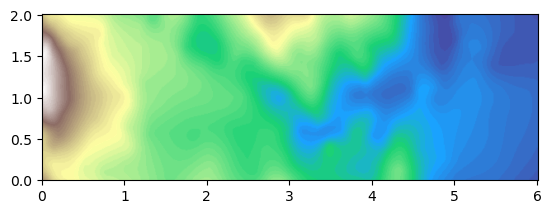

In [3]:
topo = m8r.Input(filenames[3])
o1=topo.float('o1')
d1=topo.float('d1')
n1=topo.int('n1')
o2=topo.float('o2')
d2=topo.float('d2')
n2=topo.int('n2')
top = topo.read(shape=(n2,n1)).T
plt.imshow(top.T, cmap=plt.cm.terrain, alpha=.9, 
           interpolation='bilinear', origin='lower',
           extent=(o1, o1+n1*d1, o2, o2+n2*d2))

## Topography map

In [4]:
rec_pos_ele=header.drop_duplicates(subset=['ReceiverX','ReceiverY'])
sou_pos_ele=header.drop_duplicates(subset=['SourceX_new','SourceY_new'])
x=np.concatenate((rec_pos_ele['ReceiverX'].to_numpy().astype('f'), 
                  sou_pos_ele['SourceX_new'].to_numpy().astype('f')),axis=0)
y=np.concatenate((rec_pos_ele['ReceiverY'].to_numpy().astype('f'), 
                  sou_pos_ele['SourceY_new'].to_numpy().astype('f')),axis=0)
z=np.concatenate((rec_pos_ele['ReceiverGroupElevation'].to_numpy().astype('f'), 
                  sou_pos_ele['SourceSurfaceElevation'].to_numpy().astype('f')),axis=0)

In [5]:
from scipy.interpolate import Rbf
xmin=rec_pos_ele['ReceiverX'].min()
xmax=rec_pos_ele['ReceiverX'].max()
ymin=rec_pos_ele['ReceiverY'].min()
ymax=rec_pos_ele['ReceiverY'].max()
tx = np.linspace(xmin, xmax, 250)
ty = np.linspace(ymin, ymax, 250)
XI, YI = np.meshgrid(tx, ty)
rbf = Rbf(x, y, z, function='linear')
ZI = rbf(XI, YI)

In [6]:
from scipy.interpolate import RegularGridInterpolator
txbi = np.arange(xmin, xmax, 10)
tybi = np.arange(ymin, ymax, 10)
bilinear_interp = RegularGridInterpolator((ty, tx), ZI, method='linear')
XIbi, YIbi = np.meshgrid(txbi, tybi)
points = np.array([YIbi.ravel(), XIbi.ravel()]).T
ZIbi = bilinear_interp(points)
ZIbi = ZIbi.reshape(XIbi.shape)

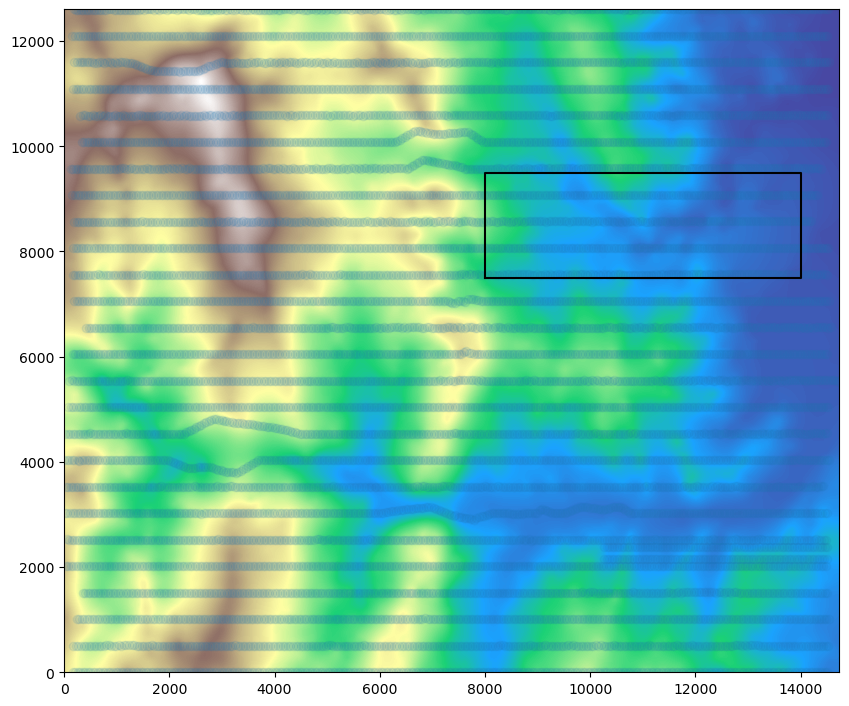

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(ZIbi, cmap=plt.cm.terrain, alpha=.9, 
           interpolation='bilinear', origin='lower',
           extent=(0, xmax-xmin, 0, ymax-ymin))
minx=8e3  #[km]
maxx=14e3 #[km]
miny=7.5e3  #[km]
maxy=9.5e3 #[km]
plt.scatter(rec_pos_ele['ReceiverX']-xmin,rec_pos_ele['ReceiverY']-ymin, alpha=0.1)
plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny],color='k')
plt.show()

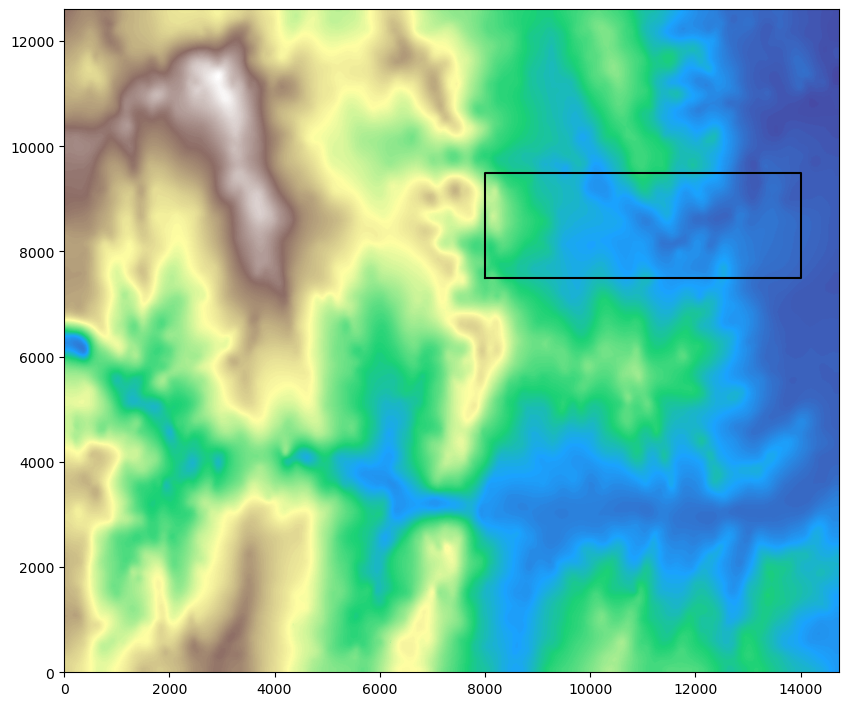

In [11]:
plt.imshow(topSEAM, cmap=plt.cm.terrain, alpha=.9, 
           interpolation='bilinear', origin='lower',
           extent=(0, xmax-xmin, 0, ymax-ymin))
plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny],color='k')

In [15]:
ZIbi.shape

(1261, 1474)

In [19]:
topSEAM.T.shape[0]

1252

In [18]:
from scipy.signal import fftconvolve
import numpy as np

# Compute the 2D cross-correlation using FFT-based convolution
correlation = fftconvolve(topSEAM.T, ZIbi[::-1, ::-1], mode='full')

# Find the index of the maximum correlation
max_idx = np.unravel_index(np.argmax(correlation), correlation.shape)

# Compute the shift based on the maximum correlation index
shift_x_calculated = max_idx[0] - topSEAM.T.shape[0] + 1
shift_y_calculated = max_idx[1] - topSEAM.T.shape[1] + 1

print(f"Calculated shift: x = {shift_x_calculated}, y = {shift_y_calculated}")


Calculated shift: x = 9, y = 27
